In [1]:
import re
import os
import sys
sys.path.insert(0, '../')
import time

import numpy as np
rng = np.random.RandomState(0)

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import astropy.constants as constants
from astropy.stats import mad_std
import astropy.units as u

import pandas as pd

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

from jas1101finalproject import GlobularCluster
from jas1101finalproject import plot
from jas1101finalproject.plot import LogNorm, AsinhNorm
from jas1101finalproject.utils import profile_binning, clip_quantile_nd
from jas1101finalproject.cluster import DBSCAN_Clustering

from jas1101finalproject.fit import sigmar_2

from jas1101finalproject.plot import colorbar_non_mappable

%load_ext autoreload
%autoreload 2

### Read GC

In [2]:
gc_name = "NGC_104_47Tuc"

GC = GlobularCluster.from_name(gc_name)
GC.table_full[:10]

x,y,pmx,pmy,pmx_e,pmy_e,pm_corr,g_mag,bp_rp,filter,memberprob,r,pm,member_prob_GMM,member_prob_DB
deg,deg,mas / yr,mas / yr,mas / yr,mas / yr,,mag,mag,,,deg,mas / yr,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
-0.1977684,-0.5888955,4.437221,-3.046831,2.568937,2.304999,-0.4350196,20.7788,0.816515,0,0.0,0.621216749580056,5.382574601935583,0.0,0.0
-0.1322767,-0.5762618,-0.06046668,-1.399454,1.140334,1.009628,-0.3081436,20.19374,0.8388195,0,0.0,0.5912484989428134,1.4007596929902795,0.0,0.0
-0.1302095,-0.5841963,25.03454,2.431298,1.950605,1.598516,-0.1853718,20.80205,2.071041,0,0.0,0.5985313950194593,25.152324007463086,0.0,0.0
-0.1348291,-0.4223898,4.965001,-1.958991,0.4321207,0.2950536,-0.2759779,18.64288,0.9655228,1,0.9608296,0.4433869972730932,5.337497603566862,1.0,0.0
-0.1274993,-0.6036617,0.6542604,-0.6097682,0.1797256,0.1373819,-0.1256039,17.40447,1.302572,1,0.0,0.6169793509894638,0.8943567122459584,0.0,0.0
-0.1955425,-0.5675544,5.504682,-9.945943,0.7583949,0.6022504,-0.2220912,19.82244,0.9101028,1,0.0,0.6002956490477088,11.36764294303674,0.0,0.0
-0.1460269,-0.5634596,4.810706,-2.849002,0.4770243,0.3784877,-0.1997244,19.0192,0.9610672,1,0.9145111,0.5820743735604326,5.591037883473872,0.0,0.0
-0.2434435,-0.5949736,0.4228585,-1.417316,0.3190453,0.2436593,-0.2938729,18.47891,1.179855,1,0.0,0.6428517110416756,1.4790517079798968,0.0,0.0


In [3]:
GC.summary

Name,ra,dec,dist,vlos,vloserr,sigma,rmax,pmra,pmdec,pmra_e,pmdec_e,pmcorr,nstar,rscale,pmdisp,pmscale,pmscale_e,pm,sc
,deg,deg,kpc,km / s,km / s,km / s,arcmin,mas / yr,mas / yr,mas / yr,mas / yr,,,arcmin,mas / yr,mas / yr,mas / yr,mas / yr,"kpc,kpc,kpc"
str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object
NGC_104_47Tuc,6.02363,-72.081,4.5,-17.2,0.2,12.2,40.0,5.237,-2.524,0.039,0.039,-0.002,23917.2,18.3,0.418,0.399,0.015,5.8134967962492246,"1.3768803520135557,0.14529010919422547,-4.281715927103217"


### Make a new GC table using HDBSCAN membership

In [54]:
dmls: u.Quantity = u.dimensionless_unscaled  # shortcut

tab_DB = GC.table_full[GC.table_full['member_prob_DB']==1]
tab_DB['pm_e'] = np.hypot(tab_DB['pmx_e'], tab_DB['pmx_e'])

GC_DB = pd.DataFrame({'r':(tab_DB["r"] / GC.rc_ang).to_value(dmls),
                      'pm':(tab_DB["pm"] / GC.pmc_ang).to_value(dmls),
                      'pm_e':(tab_DB["pm_e"] / GC.pmc_ang).to_value(dmls)})

### Distibution of PM-R with Eugene's GMM membership

Text(0, 0.5, 'PM')

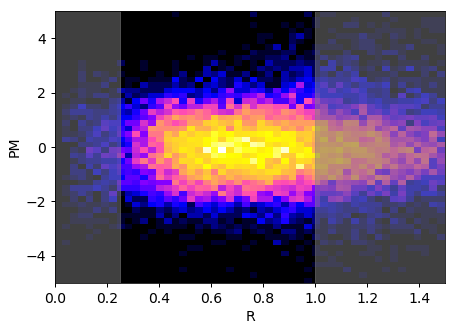

In [156]:
H, xb, yb, _ = plt.hist2d(GC.r, GC.pm-GC.pm.mean(), bins=50, range=[[0,1.5],[-5,5]], norm=AsinhNorm(), cmap="gnuplot2")

plt.axvspan(0, 0.25, 0, color="gray", alpha=0.5)
plt.axvspan(1, 1.5, 0, color="gray", alpha=0.5)
plt.xlabel("R")  # normalized
plt.ylabel("PM") # normalized

### Distibution of PM-R with HDBSCAN membership

Text(0, 0.5, 'PM')

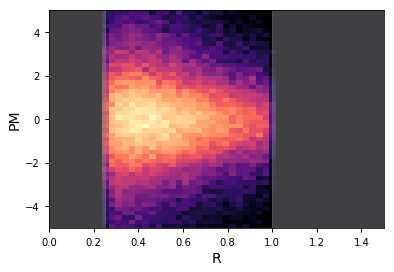

In [20]:
H, xb, yb, _ = plt.hist2d(GC_DB.r, GC_DB.pm-GC_DB.pm.mean(), bins=50, range=[[0,1.5],[-5,5]], norm=AsinhNorm(), cmap="magma")

plt.axvspan(0, 0.25, 0, color="gray", alpha=0.5)
plt.axvspan(1, 1.5, 0, color="gray", alpha=0.5)
plt.xlabel("R")  # normalized
plt.ylabel("PM") # normalized

### Draw comparison of binned sigma profiles 
#### 1) with Eugene's GMM membership
#### 2) HDBSCAN membership
#### 3) without memeber selection.

In [195]:
# parameter of GC
M_gc = 1e6
r_scale = 24

good = GC.pm_e < 2
good_DB = GC_DB.pm_e < 2

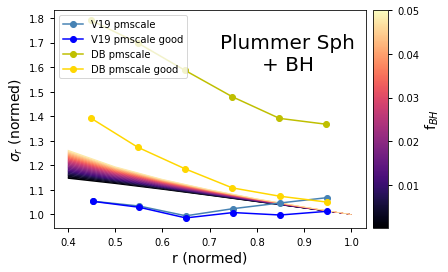

In [149]:
bins = np.linspace(0.4, 1, 7)

fig = plot.plot_binned_sigma_profile(GC.r, GC.pm, bins=bins, color='steelblue', label='V19 pmscale')
fig = plot.plot_binned_sigma_profile(GC.r[good], GC.pm[good], bins=bins, fig=fig, color='blue', label='V19 pmscale good')

fig = plot.plot_binned_sigma_profile(GC_DB.r, GC_DB.pm, bins=bins, fig=fig, color='y', label='DB pmscale')
fig = plot.plot_binned_sigma_profile(GC_DB.r[good_DB], GC_DB.pm[good_DB], bins=bins, fig=fig, color='gold', label='DB pmscale good')
plt.legend(loc=2)

(fig, ax) = plot.plot_model_sigma_profile(bins, M_gc, r_scale, beta_max=0.05, N_mod=25, fig=fig)

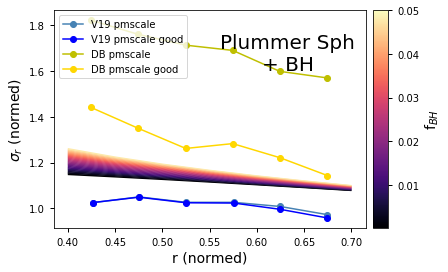

In [196]:
bins = np.linspace(0.4, 0.7, 7)

fig = plot.plot_binned_sigma_profile(GC.r, GC.pm, bins=bins, color='steelblue', label='V19 pmscale')
fig = plot.plot_binned_sigma_profile(GC.r[good], GC.pm[good], bins=bins, fig=fig, color='blue', label='V19 pmscale good')

fig = plot.plot_binned_sigma_profile(GC_DB.r, GC_DB.pm, bins=bins, fig=fig, color='y', label='DB pmscale')
fig = plot.plot_binned_sigma_profile(GC_DB.r[good_DB], GC_DB.pm[good_DB], bins=bins, fig=fig, color='gold', label='DB pmscale good')
plt.legend(loc=2)

(fig, ax) = plot.plot_model_sigma_profile(bins, M_gc, r_scale, beta_max=0.05, N_mod=25, fig=fig)

### Distribution in Radius

(0, 1.2)

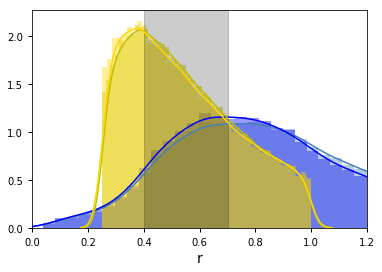

In [148]:
sns.distplot(GC.r, color='steelblue')
sns.distplot(GC.r[good], color='blue')
sns.distplot(GC_DB.r, color='y')
sns.distplot(GC_DB.r[good_DB], color='gold')
plt.axvspan(bins[0], bins[-1], color='k', alpha=0.2)
plt.xlim(0,1.2)

## Fitting sigma profile of a single cluster

In [197]:
# x and y for fitting
from jas1101finalproject.utils import convert_pm_angular

use_DB = False
if use_DB:
    r, pm, pm_e = GC_DB.r, GC_DB.pm, GC_DB.pm_e
else:
    r, pm, pm_e = GC.r, GC.pm, GC.pm_e

# conditional cut
cond = (r>=bins[0]) & (r<=bins[-1]) & (pm_e < 2)
pm, pm_e = pm[cond], pm_e[cond]
r = r[cond]

PM = 14.680 +/- 1.301 


Text(0.5, 0, 'PM')

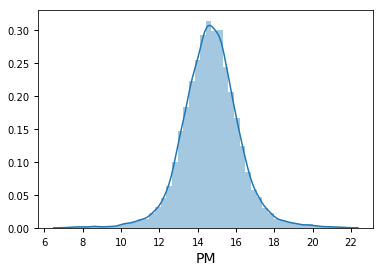

In [187]:
sns.distplot(pm)
print("PM = %.3f +/- %.3f "%(np.mean(pm), mad_std(pm)))
plt.xlabel("PM")

### Setup prior and likelihood

In [198]:
from jas1101finalproject.fit import set_prior, set_likelihood
kind = 'scale-outlier'
prior, ndim = set_prior(kind=kind, logbeta_max=-1, scale_max=25, mu_ol_max=25)
loglike = set_likelihood(r, pm, y_err=pm_e, kind=kind)

### Run Fitting

In [193]:
from jas1101finalproject.fit import DynamicNestedSampler
dsampler = DynamicNestedSampler(loglike, prior, ndim)
dsampler.run_fitting(nlive_init=200, maxbatch=2)


Opening new pool: # of CPU used: 3
Run Nested Fitting for the image... Dim of params: 6


iter: 5868 | batch: 2 | bound: 125 | nc: 1 | ncall: 33478 | eff(%): 17.528 | loglstar: -31637.853 < -31633.724 < -31635.139 | logz: -31656.486 +/-  0.452 | stop:  4.125                              



Finish Fitting! Total time elapsed: 380 s

Pool Closed.


## Visualizing Fitting Result

## 1.  Fit in 0.4 < R < 0.7

#### DBSCAN membership

with measurement error and outlier

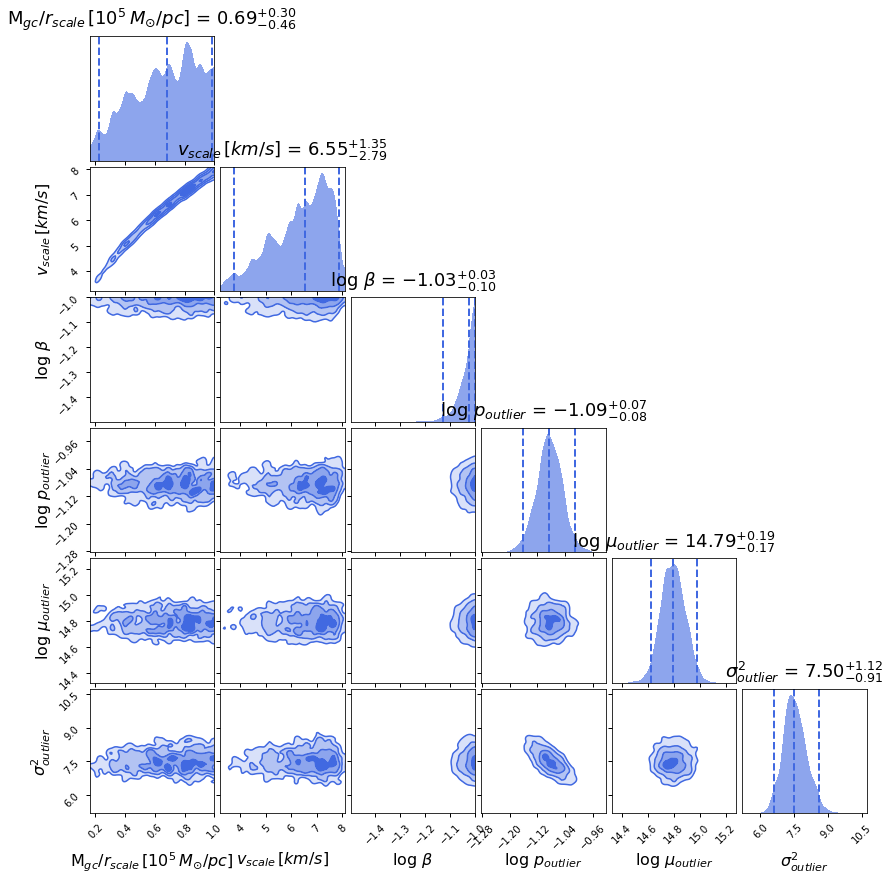

In [194]:
# Plot result joint and marginal PDF
labels = [r'M$_{gc}/r_{scale}\,[10^5\,M_{\odot}/pc]$',
          '$v_{scale}\,[km/s]$', r'log $\beta$',
          r'log $p_{outlier}$', r'log $\mu_{outlier}$', r'$\sigma^2_{outlier}$']
dsampler.cornerplot(figsize=(12,12),labels=labels)

#### Eugene's membership

without measurement error / outlier

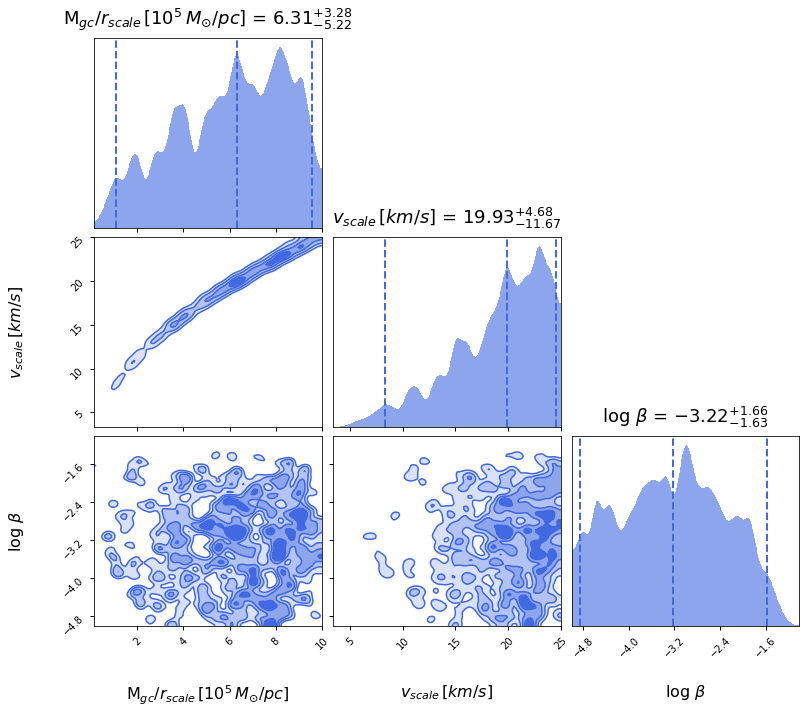

In [202]:
# Plot result joint and marginal PDF
labels = [r'M$_{gc}/r_{scale}\,[10^5\,M_{\odot}/pc]$',
          '$v_{scale}\,[km/s]$', r'log $\beta$']
dsampler.cornerplot(labels=labels)

with measurement error and outlier

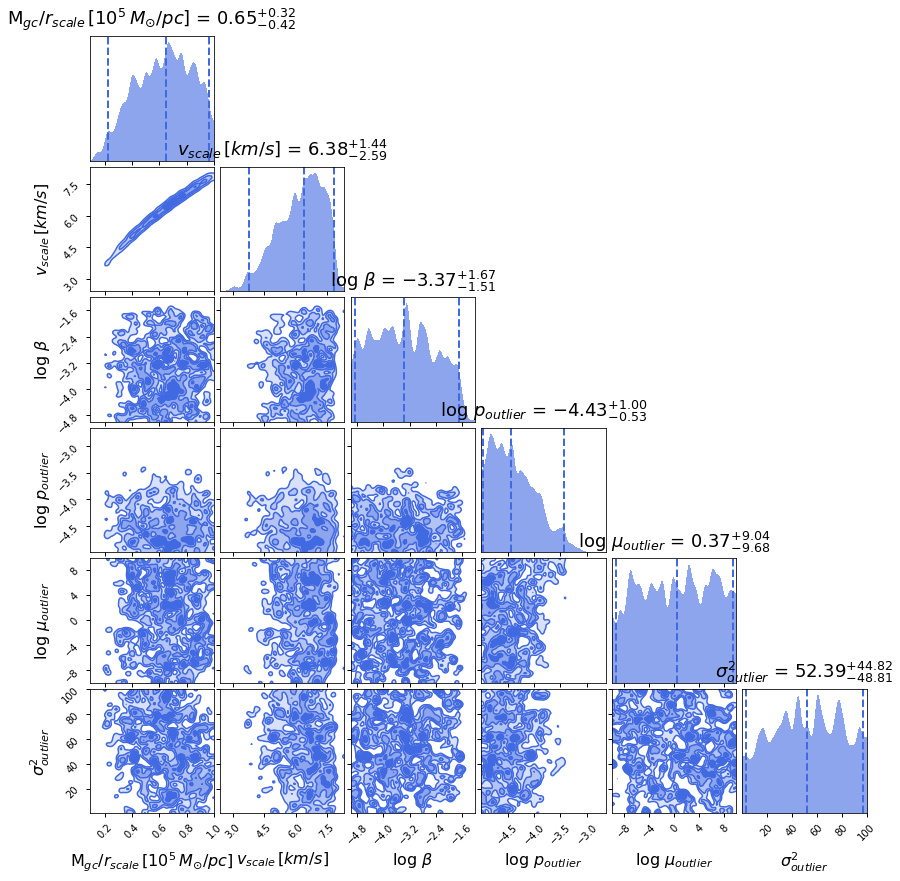

In [182]:
# Plot result joint and marginal PDF
labels = [r'M$_{gc}/r_{scale}\,[10^5\,M_{\odot}/pc]$',
          '$v_{scale}\,[km/s]$', r'log $\beta$',
          r'log $p_{outlier}$', r'log $\mu_{outlier}$', r'$\sigma^2_{outlier}$']
dsampler.cornerplot(figsize=(12,12),labels=labels)

## 2. Fit in 0.4 < R < 1

#### Eugene's membership

with measurement error and outlier

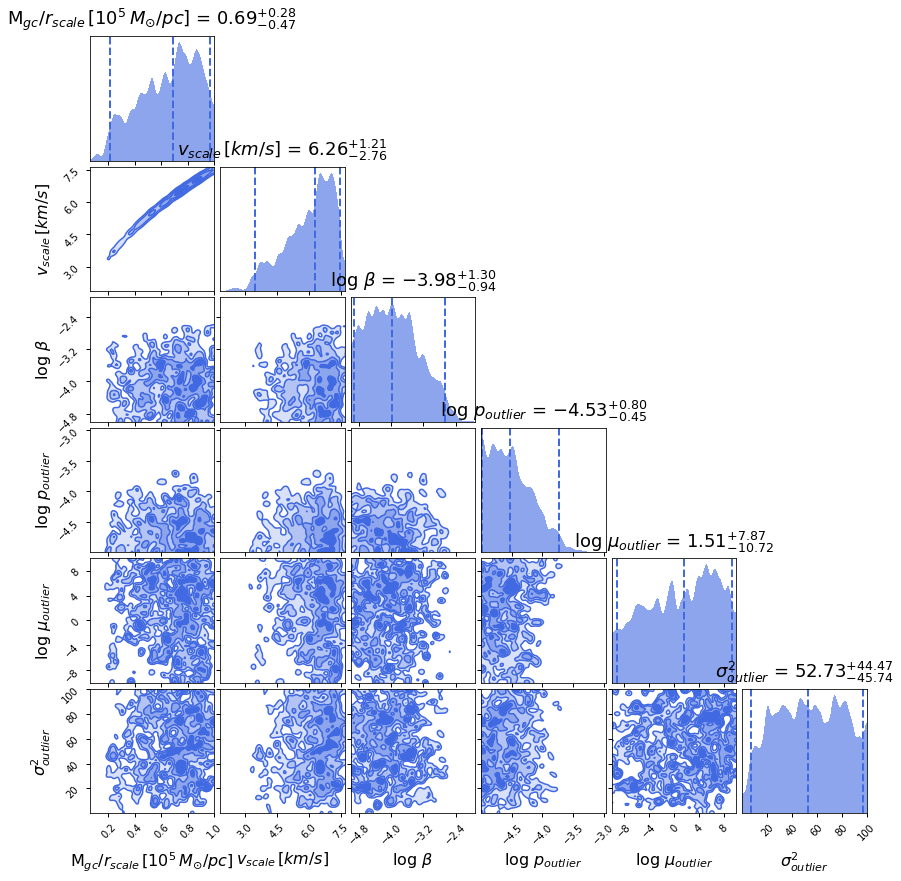

In [162]:
# Plot result joint and marginal PDF
labels = [r'M$_{gc}/r_{scale}\,[10^5\,M_{\odot}/pc]$',
          '$v_{scale}\,[km/s]$', r'log $\beta$',
          r'log $p_{outlier}$', r'log $\mu_{outlier}$', r'$\sigma^2_{outlier}$']
dsampler.cornerplot(figsize=(12,12), labels=labels)

## On Stage : Read and Stack all GCs

In [25]:
gc_names = [fname.split('.')[0] for fname in os.listdir(os.path.join(drct, 'gcs')) if fname.endswith('ecsv')]

GCs = [GlobularCluster.from_directory(name, drct) for name in gc_names]

In [26]:
r_all = np.concatenate([gc.r for gc in GCs if len(gc.table)>100])
pm_all = np.concatenate([gc.pm - gc.pm.mean() for gc in GCs if len(gc.table)>100])
print(r_all.shape)

(170871,)


Text(0.5,0,'R (normed)')

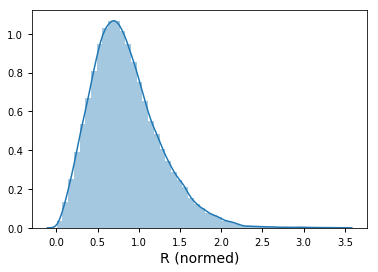

In [27]:
sns.distplot(r_all)
plt.xlabel("R (normed)")

Text(0.5,0,'PM (normed)')

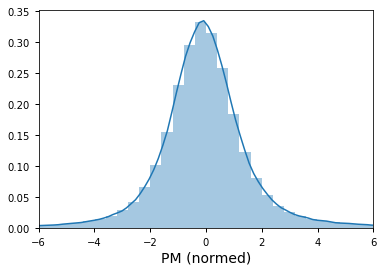

In [28]:
sns.distplot(pm_all[abs(pm_all)<10])
plt.xlim(-6,6)
plt.xlabel("PM (normed)")

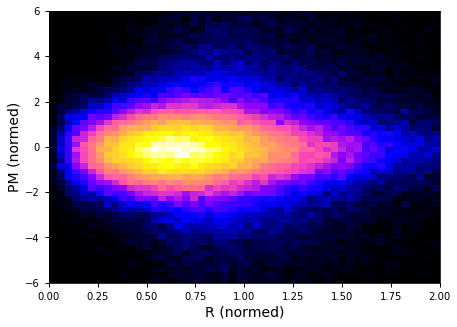

In [29]:
# display r-pm hist2d
plt.figure(figsize=(7,5))
H, xb, yb, _ = plt.hist2d(r_all, pm_all, bins=50, range=[[0,2],[-6,6]], norm=AsinhNorm(), cmap="gnuplot2")

plt.xlabel("R (normed)") # normalized
plt.ylabel("PM (normed)") # normalized
plt.show()

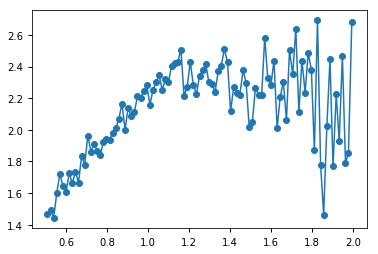

In [30]:
bins=np.linspace(0.5, 2, 100)
r_rbin, z_rbin, z_bins = profile_binning(r_all, pm_all, bins=bins, plot=False)

plt.plot(r_rbin, [np.std(z_bins[i]['pm']) for i in range(len(z_bins))],'o-')